In [ ]:
%pip install pytorch_lightning

# Importing required packages

In [1]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger

import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt

In [2]:
file_name = "CNN.csv"
url = "https://www.dropbox.com/scl/fi/x2eh2yil56rgu5id1fwbm/cnn_data1.csv?rlkey=7bltxkitlwdnuirw08r2ysuv4&st=nppxtfhe&dl=1"

response = requests.get(url)

# Save the file locally
with open(file_name, 'wb') as file:
    file.write(response.content)

In [3]:
# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(file_name)

df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']
df.loc[df['Status'] == 'OOM_CRASH', 'Max GPU Memory (MiB)'] = 42000

df = df.dropna(subset=['Activation Function'])

df = df[~df['architecture'].isin(['residual', 'dense'])]

df = df[['Max GPU Memory (MiB)', 'Depth', 'Batch Size', 'Total Parameters', 'Total Activations', 'Activations-Params', 'Activation Function',
         'Total_Activations_Batch_Size','Conv2d Count', 'BatchNorm2d Count', 'Dropout Count',
         'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)',
         'Estimated Total Size (MB)']]

# Map the existing columns to your desired column structure
df = df.rename(columns={
    'Max GPU Memory (MiB)': 'real_memory_usage',
    'Depth': 'layers',
    'Batch Size': 'batch_size',
    'Total Parameters': 'all_parameters',
    'Total Activations': 'all_activations',
    'Activations-Params': 'params_activations_list'
})

print(df.columns)

Index(['real_memory_usage', 'layers', 'batch_size', 'all_parameters',
       'all_activations', 'params_activations_list', 'Activation Function',
       'Total_Activations_Batch_Size', 'Conv2d Count', 'BatchNorm2d Count',
       'Dropout Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)'],
      dtype='object')


In [4]:
df.head()

,real_memory_usage,layers,batch_size,all_parameters,all_activations,params_activations_list,Activation Function,Total_Activations_Batch_Size,Conv2d Count,BatchNorm2d Count,Dropout Count,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB)
0,39517,69,62,1864805,195826172,"[('conv2d', 183956976, 2744), ('GELU', 1839569...",GELU,12141222664,22,0,22,21.70,123506.48,7.11,123535.29
1,42000,47,46,32924348,306385536,"[('conv2d', 44835280, 700), ('batchnorm2d', 44...",SELU,14093734656,11,11,11,2.30,134408.32,125.60,134536.22
2,6293,31,34,1730036,27443119,"[('conv2d', 33323400, 3388), ('ELU', 33323400,...",ELU,933066046,14,0,0,3.06,10678.04,6.60,10687.70
3,6475,67,10,731920,119603463,"[('conv2d', 18688000, 2044), ('batchnorm2d', 1...",ELU,1196034630,16,16,16,2.90,11406.30,2.79,11411.99
4,2779,39,18,2960902,11111315,"[('conv2d', 2230272, 640), ('batchnorm2d', 223...",ReLU,200003670,12,12,0,0.18,2034.54,11.29,2046.01


# Encoding Activation Functions

In [5]:
# List of activation functions
activations = ['ELU', 'GELU', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][1])

print(df.columns)

Index(['real_memory_usage', 'layers', 'batch_size', 'all_parameters',
       'all_activations', 'params_activations_list', 'Activation Function',
       'Total_Activations_Batch_Size', 'Conv2d Count', 'BatchNorm2d Count',
       'Dropout Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)',
       'activation_encoding_sin', 'activation_encoding_cos'],
      dtype='object')


In [6]:
import ast

# Reset the index to ensure it is in the default integer format
df = df.reset_index(drop=True)

max_layer = 0

# Check if the column 'params_activations_list' exists
if 'params_activations_list' in df.columns:
    for i in range(len(df)):
        try:
            # Check if the entry is already a list; if not, use ast.literal_eval to convert it
            entry = df['params_activations_list'].iloc[i]  # Use iloc to access the row by position

            if isinstance(entry, str):
                current_list = ast.literal_eval(entry)
            else:
                current_list = entry

            # Ensure the parsed content is a list
            if isinstance(current_list, list):
                l = len(current_list)
                if l > max_layer:
                    max_layer = l
            else:
                print(f"Unexpected format at index {i}: {entry}")

        except (ValueError, SyntaxError) as e:
            print(f"Error processing entry at index {i}: {entry} - {e}")

    print('Maximum layers:', max_layer)
else:
    print("Column 'params_activations_list' does not exist in the DataFrame.")


Maximum layers: 119


In [7]:
df.head()

,real_memory_usage,layers,batch_size,all_parameters,all_activations,params_activations_list,Activation Function,Total_Activations_Batch_Size,Conv2d Count,BatchNorm2d Count,Dropout Count,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),activation_encoding_sin,activation_encoding_cos
0,39517,69,62,1864805,195826172,"[('conv2d', 183956976, 2744), ('GELU', 1839569...",GELU,12141222664,22,0,22,21.70,123506.48,7.11,123535.29,0.309017,9.510565e-01
1,42000,47,46,32924348,306385536,"[('conv2d', 44835280, 700), ('batchnorm2d', 44...",SELU,14093734656,11,11,11,2.30,134408.32,125.60,134536.22,0.951057,-3.090170e-01
2,6293,31,34,1730036,27443119,"[('conv2d', 33323400, 3388), ('ELU', 33323400,...",ELU,933066046,14,0,0,3.06,10678.04,6.60,10687.70,0.000000,1.000000e+00
3,6475,67,10,731920,119603463,"[('conv2d', 18688000, 2044), ('batchnorm2d', 1...",ELU,1196034630,16,16,16,2.90,11406.30,2.79,11411.99,0.000000,1.000000e+00
4,2779,39,18,2960902,11111315,"[('conv2d', 2230272, 640), ('batchnorm2d', 223...",ReLU,200003670,12,12,0,0.18,2034.54,11.29,2046.01,1.000000,6.123234e-17


In [8]:
bins = [0, 8000, 16000, 24000, 32000, 40000, 50000]
labels = [i for i in range(0, len(bins) - 1)]

print(bins, labels)

# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['real_memory_usage'], bins=bins, labels=labels, right=False)

df.head()

[0, 8000, 16000, 24000, 32000, 40000, 50000] [0, 1, 2, 3, 4, 5]


,real_memory_usage,layers,batch_size,all_parameters,all_activations,params_activations_list,Activation Function,Total_Activations_Batch_Size,Conv2d Count,BatchNorm2d Count,Dropout Count,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),activation_encoding_sin,activation_encoding_cos,memory_usage_label
0,39517,69,62,1864805,195826172,"[('conv2d', 183956976, 2744), ('GELU', 1839569...",GELU,12141222664,22,0,22,21.70,123506.48,7.11,123535.29,0.309017,9.510565e-01,4
1,42000,47,46,32924348,306385536,"[('conv2d', 44835280, 700), ('batchnorm2d', 44...",SELU,14093734656,11,11,11,2.30,134408.32,125.60,134536.22,0.951057,-3.090170e-01,5
2,6293,31,34,1730036,27443119,"[('conv2d', 33323400, 3388), ('ELU', 33323400,...",ELU,933066046,14,0,0,3.06,10678.04,6.60,10687.70,0.000000,1.000000e+00,0
3,6475,67,10,731920,119603463,"[('conv2d', 18688000, 2044), ('batchnorm2d', 1...",ELU,1196034630,16,16,16,2.90,11406.30,2.79,11411.99,0.000000,1.000000e+00,0
4,2779,39,18,2960902,11111315,"[('conv2d', 2230272, 640), ('batchnorm2d', 223...",ReLU,200003670,12,12,0,0.18,2034.54,11.29,2046.01,1.000000,6.123234e-17,0


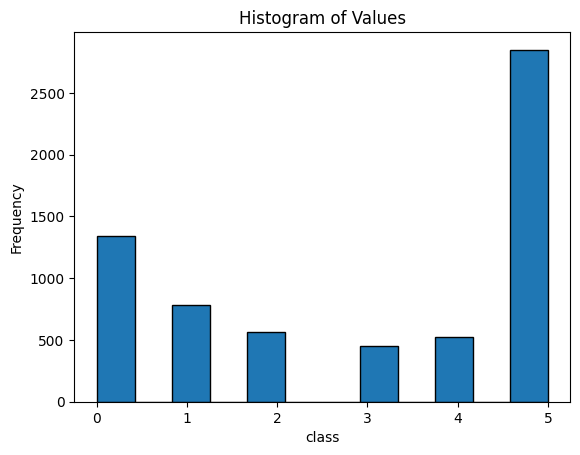

In [9]:
# Plot the histogram
plt.hist(df['memory_usage_label'], bins=len(labels)*2, edgecolor='black')  # bins can be adjusted
plt.title('Histogram of Values')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['params_activations_list', 'batch_size', 'all_parameters', 'all_activations', 'Total_Activations_Batch_Size',
        'Conv2d Count', 'BatchNorm2d Count','Dropout Count',
        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)', 'Estimated Total Size (MB)',
        'activation_encoding_sin', 'activation_encoding_cos',
       ]].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

df.columns

total data size:  6516
train size 4561, val size: 1291, test size: 664


Index(['real_memory_usage', 'layers', 'batch_size', 'all_parameters',
       'all_activations', 'params_activations_list', 'Activation Function',
       'Total_Activations_Batch_Size', 'Conv2d Count', 'BatchNorm2d Count',
       'Dropout Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)',
       'activation_encoding_sin', 'activation_encoding_cos',
       'memory_usage_label'],
      dtype='object')

# Dataloader CNN

In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def encode_layer_cnn(layer_type):
    if layer_type in ['adaptive_avg_pool2d', 'Sigmoid', 'softmax', 'ELU', 'GELU', 'Identity', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']:
        return [1, 0]
    elif layer_type == 'conv2d':
        return [0, 1]
    elif layer_type == 'linear':
        return [1, 1]
    elif layer_type in ['dropout','batchnorm2d']:
        return [0, 0]
    else:
        print(layer_type)
        raise ValueError("Unknown layer type")

# Function to process each sequence
def process_sequence(sequence):
    processed_sequence = []
    for entry in eval(sequence):  # Evaluate string as list of tuples
        layer_type, feature_1, feature_2 = entry
        # for fc
        # encoded_layer = encode_layer(layer_type)
        # for cnn
        encoded_layer = encode_layer_cnn(layer_type)
        combined = encoded_layer + [feature_1, feature_2]
        processed_sequence.append(combined)
    return np.array(processed_sequence)

def get_filtered_lists(list1, list2, list3):
    filtered_list1, filtered_list2, filtered_list3 = zip(*[(l1, l2, l3) for l1, l2, l3 in zip(list1, list2, list3) if len(l1) > 0])
    return filtered_list1, filtered_list2, filtered_list3

# Dataset preparation
class LayerSequenceDataset(Dataset):
    def __init__(self, x_data, y_labels, max_seq_len):
        self.x_data = [process_sequence(seq[0]) for seq in x_data]
        self.batch_size = [np.array(seq[1:]).astype(np.int64) for seq in x_data]
        self.y_labels = y_labels
        self.x_data, self.batch_size, self.y_labels = get_filtered_lists(self.x_data, self.batch_size, self.y_labels)
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        sequence = self.x_data[idx]
        batch_size = self.batch_size[idx]
        label = self.y_labels[idx]
        # Padding sequences to max length
        if len(sequence) < self.max_seq_len:
            padded_sequence = np.pad(sequence, ((0, self.max_seq_len - len(sequence)), (0,0)), 'constant')
        else:
            padded_sequence = sequence[:self.max_seq_len]


        return torch.tensor(padded_sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(batch_size, dtype=torch.float32)



# Example Usage
max_seq_len = max_layer  # Set the max sequence length based on your data
x_train = np.array(x_train)  # Your input sequences here
y_train = np.array(y_train)  # Your labels here

# Initialize dataset and dataloader
train_dataset = LayerSequenceDataset(x_train, y_train, max_seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

val_dataset = LayerSequenceDataset(x_val, y_val, max_seq_len)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

test_dataset = LayerSequenceDataset(x_test, y_test, max_seq_len)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

inputs, label_sample, batch_sample = next(iter(train_dataloader))
print(inputs.shape, label_sample.shape, batch_sample.shape)


torch.Size([512, 119, 4]) torch.Size([512]) torch.Size([512, 9])


# model

In [12]:
from pytorch_lightning import seed_everything

seed = 11  # Set your desired seed
seed_everything(seed, workers=True)
torch.use_deterministic_algorithms(False)


Seed set to 11


In [13]:
import torch.optim as optim

class TransformerClassifier(nn.Module):
    def __init__(self, num_features, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout, max_seq_len):
        super(TransformerClassifier, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Sequential(nn.Linear(num_features, d_model),  # Embedding layer for input features
                                        # nn.LayerNorm(d_model),
                                       nn.BatchNorm1d(max_seq_len),
                                       nn.ReLU(),
                                       nn.Linear(d_model, d_model),
                                       nn.BatchNorm1d(max_seq_len),
                                       nn.ReLU(),
                                       )
        # Positional Encoding
        self.positional_encoding = nn.Parameter(self._get_positional_encoding(max_seq_len, d_model), requires_grad=False)

        # Transformer layers
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)

        # Final classification layer
        self.fc_out = nn.Sequential(nn.Linear(d_model+9, d_model),
                                    nn.BatchNorm1d(d_model),
                                    nn.ReLU(),
                                    nn.Linear(d_model, num_classes),
        )

    def _get_positional_encoding(self, max_seq_len, d_model):
        pos_encoding = torch.zeros(max_seq_len, d_model)
        positions = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        pos_encoding[:, 0::2] = torch.sin(positions * div_term)
        pos_encoding[:, 1::2] = torch.cos(positions * div_term)

        return pos_encoding.unsqueeze(0)

    def forward(self, x, batch_size_feature):
        # Add positional encoding
        seq_len = x.size(1)
        x = self.embedding(x) + self.positional_encoding[:, :seq_len, :]

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Classification (average pooling over sequence dimension)
        x = x.sum(dim=1)  # Pool over the sequence dimension

        # Ensure batch_size_feature has the correct shape
        batch_size_feature = batch_size_feature.unsqueeze(1) if batch_size_feature.dim() == 1 else batch_size_feature

        # batch_size_feature=batch_size_feature.unsqueeze(1)
        x = torch.cat((x, batch_size_feature), dim=1)

        # Output layer for classification
        output = self.fc_out(x)

        return output

In [23]:
len(labels)

6

In [14]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = TransformerClassifier(num_features=4, num_classes=len(labels), d_model=6, nhead=3,
                                           num_layers=3, dim_feedforward=8, dropout=0, max_seq_len=max_layer)
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x, b):
        return self.model(x, b)

    def training_step(self, batch, batch_idx):
        x, y, b = batch[0], batch[1], batch[2]
        y = y.long()
        logits = self.forward(x, b)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log('train_loss', loss, on_epoch=True, on_step=True)
        self.log('train_acc', acc, on_epoch=True, on_step=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y, b = batch[0], batch[1], batch[2]
        y = y.long()
        logits = self.forward(x, b)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        self.log('val_acc', acc, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = optim.AdamW(self.parameters(), lr=0.001)

        return optimizer

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.001)

        # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'frequency': 1
            }
        }

# Callback

In [15]:
class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the training loss and accuracy logged during the epoch
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())
        self.train_accuracies.append(trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the validation loss and accuracy logged during the epoch
        self.val_losses.append(trainer.callback_metrics["val_loss"].item())
        self.val_accuracies.append(trainer.callback_metrics["val_acc"].item())

    def plot_history(self):
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label="Training Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [16]:
# Initialize the history callback
history_callback = HistoryCallback()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')

classifier_model = classification_gpu_usage(output_size = len(labels))
classifier_model.train()

/opt/miniconda3/envs/dl/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


classification_gpu_usage(
  (model): TransformerClassifier(
    (embedding): Sequential(
      (0): Linear(in_features=4, out_features=6, bias=True)
      (1): BatchNorm1d(119, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=6, out_features=6, bias=True)
      (4): BatchNorm1d(119, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
          )
          (linear1): Linear(in_features=6, out_features=8, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=8, out_features=6, bias=True)
          (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((6,)

In [17]:
trainer = pl.Trainer(
    max_epochs=600,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping, history_callback],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Ple

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/miniconda3/envs/dl/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


/opt/miniconda3/envs/dl/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 13.20it/s, v_num=0, val_loss_step=1.680, val_loss_epoch=1.670]

Metric val_loss improved. New best score: 1.674


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 17.05it/s, v_num=0, val_loss_step=1.630, val_loss_epoch=1.610]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.611


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 16.57it/s, v_num=0, val_loss_step=1.590, val_loss_epoch=1.560]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.561


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 17.35it/s, v_num=0, val_loss_step=1.560, val_loss_epoch=1.530]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.533


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 17.20it/s, v_num=0, val_loss_step=1.550, val_loss_epoch=1.510]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.515


Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 17.40it/s, v_num=0, val_loss_step=1.520, val_loss_epoch=1.480]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.482


Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 17.41it/s, v_num=0, val_loss_step=1.510, val_loss_epoch=1.470]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.467


Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 17.30it/s, v_num=0, val_loss_step=1.450, val_loss_epoch=1.410]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.411


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 17.42it/s, v_num=0, val_loss_step=1.420, val_loss_epoch=1.380]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.377


Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 17.37it/s, v_num=0, val_loss_step=1.410, val_loss_epoch=1.360]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.360


Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 17.40it/s, v_num=0, val_loss_step=1.400, val_loss_epoch=1.350]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.351


Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 17.67it/s, v_num=0, val_loss_step=1.390, val_loss_epoch=1.340]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.344


Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 17.62it/s, v_num=0, val_loss_step=1.340, val_loss_epoch=1.290]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.286


Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 17.33it/s, v_num=0, val_loss_step=1.330, val_loss_epoch=1.280]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.282


Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 17.35it/s, v_num=0, val_loss_step=1.290, val_loss_epoch=1.250]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.245


Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 17.33it/s, v_num=0, val_loss_step=1.260, val_loss_epoch=1.210]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.212


Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 16.68it/s, v_num=0, val_loss_step=1.240, val_loss_epoch=1.190]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.192


Epoch 31: 100%|██████████| 9/9 [00:00<00:00, 17.66it/s, v_num=0, val_loss_step=1.220, val_loss_epoch=1.180]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.176


Epoch 33: 100%|██████████| 9/9 [00:00<00:00, 16.79it/s, v_num=0, val_loss_step=1.200, val_loss_epoch=1.160]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.156


Epoch 38: 100%|██████████| 9/9 [00:00<00:00, 16.74it/s, v_num=0, val_loss_step=1.180, val_loss_epoch=1.140]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.141


Epoch 39: 100%|██████████| 9/9 [00:00<00:00, 17.45it/s, v_num=0, val_loss_step=1.160, val_loss_epoch=1.120]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.124


Epoch 41: 100%|██████████| 9/9 [00:00<00:00, 17.28it/s, v_num=0, val_loss_step=1.140, val_loss_epoch=1.100]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.100


Epoch 44: 100%|██████████| 9/9 [00:00<00:00, 16.76it/s, v_num=0, val_loss_step=1.120, val_loss_epoch=1.090]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.088


Epoch 45: 100%|██████████| 9/9 [00:00<00:00, 17.59it/s, v_num=0, val_loss_step=1.120, val_loss_epoch=1.090]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.086


Epoch 46: 100%|██████████| 9/9 [00:00<00:00, 17.54it/s, v_num=0, val_loss_step=1.120, val_loss_epoch=1.080]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.083


Epoch 47: 100%|██████████| 9/9 [00:00<00:00, 17.61it/s, v_num=0, val_loss_step=1.100, val_loss_epoch=1.070]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.071


Epoch 48: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, v_num=0, val_loss_step=1.100, val_loss_epoch=1.070]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.070


Epoch 50: 100%|██████████| 9/9 [00:00<00:00, 17.57it/s, v_num=0, val_loss_step=1.080, val_loss_epoch=1.050]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.053


Epoch 53: 100%|██████████| 9/9 [00:00<00:00, 17.53it/s, v_num=0, val_loss_step=1.070, val_loss_epoch=1.040]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.042


Epoch 55: 100%|██████████| 9/9 [00:00<00:00, 16.61it/s, v_num=0, val_loss_step=1.070, val_loss_epoch=1.040]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.040


Epoch 56: 100%|██████████| 9/9 [00:00<00:00, 16.97it/s, v_num=0, val_loss_step=1.060, val_loss_epoch=1.030]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.035


Epoch 57: 100%|██████████| 9/9 [00:00<00:00, 17.39it/s, v_num=0, val_loss_step=1.050, val_loss_epoch=1.030]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.029


Epoch 58: 100%|██████████| 9/9 [00:00<00:00, 17.42it/s, v_num=0, val_loss_step=1.050, val_loss_epoch=1.030]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.025


Epoch 59: 100%|██████████| 9/9 [00:00<00:00, 17.49it/s, v_num=0, val_loss_step=1.040, val_loss_epoch=1.020]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.018


Epoch 60: 100%|██████████| 9/9 [00:00<00:00, 17.48it/s, v_num=0, val_loss_step=1.040, val_loss_epoch=1.010]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.014


Epoch 61: 100%|██████████| 9/9 [00:00<00:00, 16.68it/s, v_num=0, val_loss_step=1.040, val_loss_epoch=1.010]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.013


Epoch 62: 100%|██████████| 9/9 [00:00<00:00, 17.71it/s, v_num=0, val_loss_step=1.030, val_loss_epoch=1.010]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.010


Epoch 63: 100%|██████████| 9/9 [00:00<00:00, 17.68it/s, v_num=0, val_loss_step=1.030, val_loss_epoch=1.010]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.006


Epoch 64: 100%|██████████| 9/9 [00:00<00:00, 17.62it/s, v_num=0, val_loss_step=1.020, val_loss_epoch=0.998]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.998


Epoch 65: 100%|██████████| 9/9 [00:00<00:00, 17.73it/s, v_num=0, val_loss_step=1.010, val_loss_epoch=0.995]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.995


Epoch 66: 100%|██████████| 9/9 [00:00<00:00, 16.91it/s, v_num=0, val_loss_step=1.010, val_loss_epoch=0.989]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.989


Epoch 68: 100%|██████████| 9/9 [00:00<00:00, 17.70it/s, v_num=0, val_loss_step=1.000, val_loss_epoch=0.986]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.986


Epoch 69: 100%|██████████| 9/9 [00:00<00:00, 17.45it/s, v_num=0, val_loss_step=0.995, val_loss_epoch=0.979]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.979


Epoch 70: 100%|██████████| 9/9 [00:00<00:00, 17.50it/s, v_num=0, val_loss_step=0.990, val_loss_epoch=0.974]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.974


Epoch 71: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, v_num=0, val_loss_step=0.985, val_loss_epoch=0.970]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.970


Epoch 72: 100%|██████████| 9/9 [00:00<00:00, 16.91it/s, v_num=0, val_loss_step=0.977, val_loss_epoch=0.963]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.963


Epoch 74: 100%|██████████| 9/9 [00:00<00:00, 17.58it/s, v_num=0, val_loss_step=0.969, val_loss_epoch=0.955]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.955


Epoch 75: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, v_num=0, val_loss_step=0.963, val_loss_epoch=0.950]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.950


Epoch 77: 100%|██████████| 9/9 [00:00<00:00, 16.81it/s, v_num=0, val_loss_step=0.958, val_loss_epoch=0.945]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.945


Epoch 78: 100%|██████████| 9/9 [00:00<00:00, 17.49it/s, v_num=0, val_loss_step=0.949, val_loss_epoch=0.938]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.938


Epoch 80: 100%|██████████| 9/9 [00:00<00:00, 17.35it/s, v_num=0, val_loss_step=0.947, val_loss_epoch=0.935]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.935


Epoch 81: 100%|██████████| 9/9 [00:00<00:00, 17.66it/s, v_num=0, val_loss_step=0.944, val_loss_epoch=0.932]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.932


Epoch 82: 100%|██████████| 9/9 [00:00<00:00, 17.36it/s, v_num=0, val_loss_step=0.936, val_loss_epoch=0.925]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.925


Epoch 83: 100%|██████████| 9/9 [00:00<00:00, 16.80it/s, v_num=0, val_loss_step=0.935, val_loss_epoch=0.923]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.923


Epoch 84: 100%|██████████| 9/9 [00:00<00:00, 17.79it/s, v_num=0, val_loss_step=0.930, val_loss_epoch=0.918]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.918


Epoch 85: 100%|██████████| 9/9 [00:00<00:00, 12.86it/s, v_num=0, val_loss_step=0.927, val_loss_epoch=0.915]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.915


Epoch 86: 100%|██████████| 9/9 [00:00<00:00, 17.36it/s, v_num=0, val_loss_step=0.926, val_loss_epoch=0.914]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.914


Epoch 87: 100%|██████████| 9/9 [00:00<00:00, 17.71it/s, v_num=0, val_loss_step=0.918, val_loss_epoch=0.907]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.907


Epoch 88: 100%|██████████| 9/9 [00:00<00:00, 16.97it/s, v_num=0, val_loss_step=0.914, val_loss_epoch=0.903]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.903


Epoch 89: 100%|██████████| 9/9 [00:00<00:00, 17.21it/s, v_num=0, val_loss_step=0.910, val_loss_epoch=0.899]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.899


Epoch 90: 100%|██████████| 9/9 [00:00<00:00, 17.47it/s, v_num=0, val_loss_step=0.907, val_loss_epoch=0.896]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.896


Epoch 91: 100%|██████████| 9/9 [00:00<00:00, 17.57it/s, v_num=0, val_loss_step=0.902, val_loss_epoch=0.891]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.891


Epoch 92: 100%|██████████| 9/9 [00:00<00:00, 17.38it/s, v_num=0, val_loss_step=0.901, val_loss_epoch=0.890]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.890


Epoch 93: 100%|██████████| 9/9 [00:00<00:00, 17.40it/s, v_num=0, val_loss_step=0.899, val_loss_epoch=0.888]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.888


Epoch 94: 100%|██████████| 9/9 [00:00<00:00, 16.72it/s, v_num=0, val_loss_step=0.897, val_loss_epoch=0.885]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.885


Epoch 95: 100%|██████████| 9/9 [00:00<00:00, 17.72it/s, v_num=0, val_loss_step=0.893, val_loss_epoch=0.882]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.882


Epoch 96: 100%|██████████| 9/9 [00:00<00:00, 17.61it/s, v_num=0, val_loss_step=0.891, val_loss_epoch=0.879]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.879


Epoch 97: 100%|██████████| 9/9 [00:00<00:00, 17.53it/s, v_num=0, val_loss_step=0.890, val_loss_epoch=0.878]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.878


Epoch 98: 100%|██████████| 9/9 [00:00<00:00, 17.57it/s, v_num=0, val_loss_step=0.886, val_loss_epoch=0.875]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.875


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 16.97it/s, v_num=0, val_loss_step=0.883, val_loss_epoch=0.872]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.872


Epoch 100: 100%|██████████| 9/9 [00:00<00:00, 17.54it/s, v_num=0, val_loss_step=0.882, val_loss_epoch=0.871]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.871


Epoch 101: 100%|██████████| 9/9 [00:00<00:00, 17.36it/s, v_num=0, val_loss_step=0.877, val_loss_epoch=0.866]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.866


Epoch 102: 100%|██████████| 9/9 [00:00<00:00, 17.43it/s, v_num=0, val_loss_step=0.875, val_loss_epoch=0.864]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.864


Epoch 103: 100%|██████████| 9/9 [00:00<00:00, 18.03it/s, v_num=0, val_loss_step=0.871, val_loss_epoch=0.861]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.861


Epoch 104: 100%|██████████| 9/9 [00:00<00:00, 17.84it/s, v_num=0, val_loss_step=0.868, val_loss_epoch=0.858]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.858


Epoch 105: 100%|██████████| 9/9 [00:00<00:00, 16.94it/s, v_num=0, val_loss_step=0.868, val_loss_epoch=0.857]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.857


Epoch 106: 100%|██████████| 9/9 [00:00<00:00, 17.55it/s, v_num=0, val_loss_step=0.864, val_loss_epoch=0.854]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.854


Epoch 107: 100%|██████████| 9/9 [00:00<00:00, 17.59it/s, v_num=0, val_loss_step=0.863, val_loss_epoch=0.853]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.853


Epoch 108: 100%|██████████| 9/9 [00:00<00:00, 17.54it/s, v_num=0, val_loss_step=0.860, val_loss_epoch=0.850]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.850


Epoch 109: 100%|██████████| 9/9 [00:00<00:00, 17.61it/s, v_num=0, val_loss_step=0.857, val_loss_epoch=0.848]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.848


Epoch 110: 100%|██████████| 9/9 [00:00<00:00, 17.51it/s, v_num=0, val_loss_step=0.857, val_loss_epoch=0.847]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.847


Epoch 111: 100%|██████████| 9/9 [00:00<00:00, 16.83it/s, v_num=0, val_loss_step=0.855, val_loss_epoch=0.845]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.845


Epoch 112: 100%|██████████| 9/9 [00:00<00:00, 17.46it/s, v_num=0, val_loss_step=0.853, val_loss_epoch=0.844]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.844


Epoch 113: 100%|██████████| 9/9 [00:00<00:00, 17.58it/s, v_num=0, val_loss_step=0.852, val_loss_epoch=0.842]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.842


Epoch 114: 100%|██████████| 9/9 [00:00<00:00, 17.23it/s, v_num=0, val_loss_step=0.848, val_loss_epoch=0.838]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.838


Epoch 115: 100%|██████████| 9/9 [00:00<00:00, 17.27it/s, v_num=0, val_loss_step=0.846, val_loss_epoch=0.837]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.837


Epoch 116: 100%|██████████| 9/9 [00:00<00:00, 16.70it/s, v_num=0, val_loss_step=0.842, val_loss_epoch=0.833]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.833


Epoch 117: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, v_num=0, val_loss_step=0.840, val_loss_epoch=0.832]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.832


Epoch 118: 100%|██████████| 9/9 [00:00<00:00, 17.62it/s, v_num=0, val_loss_step=0.839, val_loss_epoch=0.830]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.830


Epoch 119: 100%|██████████| 9/9 [00:00<00:00, 17.59it/s, v_num=0, val_loss_step=0.836, val_loss_epoch=0.828]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.828


Epoch 120: 100%|██████████| 9/9 [00:00<00:00, 17.58it/s, v_num=0, val_loss_step=0.834, val_loss_epoch=0.826]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.826


Epoch 121: 100%|██████████| 9/9 [00:00<00:00, 17.66it/s, v_num=0, val_loss_step=0.832, val_loss_epoch=0.824]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.824


Epoch 122: 100%|██████████| 9/9 [00:00<00:00, 16.58it/s, v_num=0, val_loss_step=0.830, val_loss_epoch=0.822]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.822


Epoch 123: 100%|██████████| 9/9 [00:00<00:00, 17.48it/s, v_num=0, val_loss_step=0.829, val_loss_epoch=0.821]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.821


Epoch 124: 100%|██████████| 9/9 [00:00<00:00, 17.52it/s, v_num=0, val_loss_step=0.825, val_loss_epoch=0.817]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.817


Epoch 125: 100%|██████████| 9/9 [00:00<00:00, 17.50it/s, v_num=0, val_loss_step=0.825, val_loss_epoch=0.817]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.817


Epoch 126: 100%|██████████| 9/9 [00:00<00:00, 17.45it/s, v_num=0, val_loss_step=0.823, val_loss_epoch=0.815]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.815


Epoch 127: 100%|██████████| 9/9 [00:00<00:00, 17.06it/s, v_num=0, val_loss_step=0.821, val_loss_epoch=0.814]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.814


Epoch 128: 100%|██████████| 9/9 [00:00<00:00, 17.44it/s, v_num=0, val_loss_step=0.819, val_loss_epoch=0.812]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.812


Epoch 129: 100%|██████████| 9/9 [00:00<00:00, 17.72it/s, v_num=0, val_loss_step=0.817, val_loss_epoch=0.809]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.809


Epoch 130: 100%|██████████| 9/9 [00:00<00:00, 17.66it/s, v_num=0, val_loss_step=0.815, val_loss_epoch=0.807]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.807


Epoch 131: 100%|██████████| 9/9 [00:00<00:00, 17.69it/s, v_num=0, val_loss_step=0.812, val_loss_epoch=0.805]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.805


Epoch 132: 100%|██████████| 9/9 [00:00<00:00, 17.71it/s, v_num=0, val_loss_step=0.808, val_loss_epoch=0.802]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.802


Epoch 134: 100%|██████████| 9/9 [00:00<00:00, 17.67it/s, v_num=0, val_loss_step=0.808, val_loss_epoch=0.801]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.801


Epoch 135: 100%|██████████| 9/9 [00:00<00:00, 17.61it/s, v_num=0, val_loss_step=0.805, val_loss_epoch=0.799]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.799


Epoch 136: 100%|██████████| 9/9 [00:00<00:00, 12.78it/s, v_num=0, val_loss_step=0.805, val_loss_epoch=0.798]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.798


Epoch 137: 100%|██████████| 9/9 [00:00<00:00, 17.59it/s, v_num=0, val_loss_step=0.802, val_loss_epoch=0.796]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.796


Epoch 138: 100%|██████████| 9/9 [00:00<00:00, 16.89it/s, v_num=0, val_loss_step=0.799, val_loss_epoch=0.793]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.793


Epoch 139: 100%|██████████| 9/9 [00:00<00:00, 17.02it/s, v_num=0, val_loss_step=0.797, val_loss_epoch=0.791]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.791


Epoch 140: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, v_num=0, val_loss_step=0.796, val_loss_epoch=0.790]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.790


Epoch 141: 100%|██████████| 9/9 [00:00<00:00, 17.63it/s, v_num=0, val_loss_step=0.795, val_loss_epoch=0.789]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.789


Epoch 142: 100%|██████████| 9/9 [00:00<00:00, 17.61it/s, v_num=0, val_loss_step=0.795, val_loss_epoch=0.789]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.789


Epoch 143: 100%|██████████| 9/9 [00:00<00:00, 17.69it/s, v_num=0, val_loss_step=0.791, val_loss_epoch=0.785]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.785


Epoch 144: 100%|██████████| 9/9 [00:00<00:00, 16.76it/s, v_num=0, val_loss_step=0.790, val_loss_epoch=0.784]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.784


Epoch 145: 100%|██████████| 9/9 [00:00<00:00, 17.28it/s, v_num=0, val_loss_step=0.787, val_loss_epoch=0.781]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.781


Epoch 146: 100%|██████████| 9/9 [00:00<00:00, 17.21it/s, v_num=0, val_loss_step=0.784, val_loss_epoch=0.779]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.779


Epoch 147: 100%|██████████| 9/9 [00:00<00:00, 17.69it/s, v_num=0, val_loss_step=0.783, val_loss_epoch=0.778]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.778


Epoch 149: 100%|██████████| 9/9 [00:00<00:00, 17.13it/s, v_num=0, val_loss_step=0.780, val_loss_epoch=0.776]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.776


Epoch 150: 100%|██████████| 9/9 [00:00<00:00, 17.74it/s, v_num=0, val_loss_step=0.779, val_loss_epoch=0.774]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.774


Epoch 151: 100%|██████████| 9/9 [00:00<00:00, 17.77it/s, v_num=0, val_loss_step=0.777, val_loss_epoch=0.772]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.772


Epoch 152: 100%|██████████| 9/9 [00:00<00:00, 17.51it/s, v_num=0, val_loss_step=0.776, val_loss_epoch=0.771]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.771


Epoch 153: 100%|██████████| 9/9 [00:00<00:00, 17.72it/s, v_num=0, val_loss_step=0.773, val_loss_epoch=0.768]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.768


Epoch 154: 100%|██████████| 9/9 [00:00<00:00, 17.57it/s, v_num=0, val_loss_step=0.769, val_loss_epoch=0.765]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.765


Epoch 155: 100%|██████████| 9/9 [00:00<00:00, 16.97it/s, v_num=0, val_loss_step=0.769, val_loss_epoch=0.765]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.765


Epoch 157: 100%|██████████| 9/9 [00:00<00:00, 17.66it/s, v_num=0, val_loss_step=0.769, val_loss_epoch=0.765]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.765


Epoch 158: 100%|██████████| 9/9 [00:00<00:00, 17.43it/s, v_num=0, val_loss_step=0.766, val_loss_epoch=0.762]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.762


Epoch 159: 100%|██████████| 9/9 [00:00<00:00, 17.90it/s, v_num=0, val_loss_step=0.766, val_loss_epoch=0.762]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.762


Epoch 160: 100%|██████████| 9/9 [00:00<00:00, 17.80it/s, v_num=0, val_loss_step=0.764, val_loss_epoch=0.760]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.760


Epoch 161: 100%|██████████| 9/9 [00:00<00:00, 17.13it/s, v_num=0, val_loss_step=0.763, val_loss_epoch=0.759]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.759


Epoch 162: 100%|██████████| 9/9 [00:00<00:00, 17.47it/s, v_num=0, val_loss_step=0.761, val_loss_epoch=0.758]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.758


Epoch 163: 100%|██████████| 9/9 [00:00<00:00, 17.52it/s, v_num=0, val_loss_step=0.758, val_loss_epoch=0.754]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.754


Epoch 164: 100%|██████████| 9/9 [00:00<00:00, 17.90it/s, v_num=0, val_loss_step=0.756, val_loss_epoch=0.752]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.752


Epoch 165: 100%|██████████| 9/9 [00:00<00:00, 17.80it/s, v_num=0, val_loss_step=0.755, val_loss_epoch=0.751]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.751


Epoch 166: 100%|██████████| 9/9 [00:00<00:00, 17.08it/s, v_num=0, val_loss_step=0.753, val_loss_epoch=0.750]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.750


Epoch 167: 100%|██████████| 9/9 [00:00<00:00, 17.15it/s, v_num=0, val_loss_step=0.752, val_loss_epoch=0.749]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.749


Epoch 168: 100%|██████████| 9/9 [00:00<00:00, 17.18it/s, v_num=0, val_loss_step=0.749, val_loss_epoch=0.746]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.746


Epoch 170: 100%|██████████| 9/9 [00:00<00:00, 17.54it/s, v_num=0, val_loss_step=0.748, val_loss_epoch=0.745]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.745


Epoch 171: 100%|██████████| 9/9 [00:00<00:00, 17.49it/s, v_num=0, val_loss_step=0.746, val_loss_epoch=0.743]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.743


Epoch 172: 100%|██████████| 9/9 [00:00<00:00, 16.97it/s, v_num=0, val_loss_step=0.744, val_loss_epoch=0.741]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.741


Epoch 173: 100%|██████████| 9/9 [00:00<00:00, 17.54it/s, v_num=0, val_loss_step=0.743, val_loss_epoch=0.740]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.740


Epoch 174: 100%|██████████| 9/9 [00:00<00:00, 17.59it/s, v_num=0, val_loss_step=0.741, val_loss_epoch=0.738]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.738


Epoch 177: 100%|██████████| 9/9 [00:00<00:00, 16.52it/s, v_num=0, val_loss_step=0.739, val_loss_epoch=0.736]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.736


Epoch 178: 100%|██████████| 9/9 [00:00<00:00, 17.36it/s, v_num=0, val_loss_step=0.735, val_loss_epoch=0.733]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.733


Epoch 179: 100%|██████████| 9/9 [00:00<00:00, 17.35it/s, v_num=0, val_loss_step=0.734, val_loss_epoch=0.732]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.732


Epoch 180: 100%|██████████| 9/9 [00:00<00:00, 17.28it/s, v_num=0, val_loss_step=0.732, val_loss_epoch=0.731]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.731


Epoch 181: 100%|██████████| 9/9 [00:00<00:00, 17.16it/s, v_num=0, val_loss_step=0.731, val_loss_epoch=0.730]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.730


Epoch 182: 100%|██████████| 9/9 [00:00<00:00, 17.57it/s, v_num=0, val_loss_step=0.730, val_loss_epoch=0.729]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.729


Epoch 183: 100%|██████████| 9/9 [00:00<00:00, 16.93it/s, v_num=0, val_loss_step=0.730, val_loss_epoch=0.729]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.729


Epoch 184: 100%|██████████| 9/9 [00:00<00:00, 17.40it/s, v_num=0, val_loss_step=0.728, val_loss_epoch=0.727]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.727


Epoch 185: 100%|██████████| 9/9 [00:00<00:00, 17.52it/s, v_num=0, val_loss_step=0.726, val_loss_epoch=0.725]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.725


Epoch 186: 100%|██████████| 9/9 [00:00<00:00, 13.13it/s, v_num=0, val_loss_step=0.725, val_loss_epoch=0.724]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.724


Epoch 187: 100%|██████████| 9/9 [00:00<00:00, 17.57it/s, v_num=0, val_loss_step=0.724, val_loss_epoch=0.723]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.723


Epoch 189: 100%|██████████| 9/9 [00:00<00:00, 17.47it/s, v_num=0, val_loss_step=0.722, val_loss_epoch=0.721]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.721


Epoch 190: 100%|██████████| 9/9 [00:00<00:00, 17.44it/s, v_num=0, val_loss_step=0.719, val_loss_epoch=0.719]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.719


Epoch 191: 100%|██████████| 9/9 [00:00<00:00, 17.50it/s, v_num=0, val_loss_step=0.717, val_loss_epoch=0.717]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.717


Epoch 192: 100%|██████████| 9/9 [00:00<00:00, 17.29it/s, v_num=0, val_loss_step=0.715, val_loss_epoch=0.715]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.715


Epoch 193: 100%|██████████| 9/9 [00:00<00:00, 17.46it/s, v_num=0, val_loss_step=0.714, val_loss_epoch=0.714]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.714


Epoch 195: 100%|██████████| 9/9 [00:00<00:00, 17.23it/s, v_num=0, val_loss_step=0.713, val_loss_epoch=0.714]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.714


Epoch 196: 100%|██████████| 9/9 [00:00<00:00, 17.46it/s, v_num=0, val_loss_step=0.711, val_loss_epoch=0.711]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.711


Epoch 197: 100%|██████████| 9/9 [00:00<00:00, 17.50it/s, v_num=0, val_loss_step=0.710, val_loss_epoch=0.711]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.711


Epoch 199: 100%|██████████| 9/9 [00:00<00:00, 17.00it/s, v_num=0, val_loss_step=0.708, val_loss_epoch=0.709]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.709


Epoch 200: 100%|██████████| 9/9 [00:00<00:00, 17.59it/s, v_num=0, val_loss_step=0.706, val_loss_epoch=0.707]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.707


Epoch 201: 100%|██████████| 9/9 [00:00<00:00, 17.55it/s, v_num=0, val_loss_step=0.706, val_loss_epoch=0.707]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.707


Epoch 202: 100%|██████████| 9/9 [00:00<00:00, 17.57it/s, v_num=0, val_loss_step=0.703, val_loss_epoch=0.704]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.704


Epoch 203: 100%|██████████| 9/9 [00:00<00:00, 17.60it/s, v_num=0, val_loss_step=0.703, val_loss_epoch=0.704]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.704


Epoch 204: 100%|██████████| 9/9 [00:00<00:00, 17.57it/s, v_num=0, val_loss_step=0.702, val_loss_epoch=0.703]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.703


Epoch 205: 100%|██████████| 9/9 [00:00<00:00, 16.86it/s, v_num=0, val_loss_step=0.699, val_loss_epoch=0.701]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.701


Epoch 206: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, v_num=0, val_loss_step=0.699, val_loss_epoch=0.701]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.701


Epoch 207: 100%|██████████| 9/9 [00:00<00:00, 17.53it/s, v_num=0, val_loss_step=0.695, val_loss_epoch=0.697]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.697


Epoch 210: 100%|██████████| 9/9 [00:00<00:00, 18.46it/s, v_num=0, val_loss_step=0.692, val_loss_epoch=0.695]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.695


Epoch 213: 100%|██████████| 9/9 [00:00<00:00, 17.50it/s, v_num=0, val_loss_step=0.692, val_loss_epoch=0.695]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.695


Epoch 214: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, v_num=0, val_loss_step=0.685, val_loss_epoch=0.688]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.688


Epoch 219: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, v_num=0, val_loss_step=0.682, val_loss_epoch=0.686]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.686


Epoch 222: 100%|██████████| 9/9 [00:00<00:00, 16.87it/s, v_num=0, val_loss_step=0.680, val_loss_epoch=0.684]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.684


Epoch 223: 100%|██████████| 9/9 [00:00<00:00, 17.18it/s, v_num=0, val_loss_step=0.677, val_loss_epoch=0.681]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.681


Epoch 224: 100%|██████████| 9/9 [00:00<00:00, 17.62it/s, v_num=0, val_loss_step=0.675, val_loss_epoch=0.679]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.679


Epoch 225: 100%|██████████| 9/9 [00:00<00:00, 17.51it/s, v_num=0, val_loss_step=0.674, val_loss_epoch=0.678]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.678


Epoch 230: 100%|██████████| 9/9 [00:00<00:00, 17.00it/s, v_num=0, val_loss_step=0.672, val_loss_epoch=0.677]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.677


Epoch 231: 100%|██████████| 9/9 [00:00<00:00, 17.47it/s, v_num=0, val_loss_step=0.669, val_loss_epoch=0.675]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.675


Epoch 232: 100%|██████████| 9/9 [00:00<00:00, 17.57it/s, v_num=0, val_loss_step=0.668, val_loss_epoch=0.674]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.674


Epoch 234: 100%|██████████| 9/9 [00:00<00:00, 17.45it/s, v_num=0, val_loss_step=0.666, val_loss_epoch=0.672]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.672


Epoch 235: 100%|██████████| 9/9 [00:00<00:00, 17.51it/s, v_num=0, val_loss_step=0.665, val_loss_epoch=0.670]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.670


Epoch 236: 100%|██████████| 9/9 [00:00<00:00, 17.52it/s, v_num=0, val_loss_step=0.663, val_loss_epoch=0.669]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.669


Epoch 237: 100%|██████████| 9/9 [00:00<00:00, 12.95it/s, v_num=0, val_loss_step=0.662, val_loss_epoch=0.668]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.668


Epoch 239: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, v_num=0, val_loss_step=0.661, val_loss_epoch=0.668]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.668


Epoch 240: 100%|██████████| 9/9 [00:00<00:00, 17.59it/s, v_num=0, val_loss_step=0.659, val_loss_epoch=0.665]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.665


Epoch 241: 100%|██████████| 9/9 [00:00<00:00, 17.47it/s, v_num=0, val_loss_step=0.656, val_loss_epoch=0.663]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.663


Epoch 243: 100%|██████████| 9/9 [00:00<00:00, 17.41it/s, v_num=0, val_loss_step=0.656, val_loss_epoch=0.662]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.662


Epoch 244: 100%|██████████| 9/9 [00:00<00:00, 16.74it/s, v_num=0, val_loss_step=0.654, val_loss_epoch=0.661]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.661


Epoch 249: 100%|██████████| 9/9 [00:00<00:00, 16.42it/s, v_num=0, val_loss_step=0.647, val_loss_epoch=0.654]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.654


Epoch 254: 100%|██████████| 9/9 [00:00<00:00, 17.50it/s, v_num=0, val_loss_step=0.642, val_loss_epoch=0.650]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.650


Epoch 260: 100%|██████████| 9/9 [00:00<00:00, 17.51it/s, v_num=0, val_loss_step=0.640, val_loss_epoch=0.648]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.648


Epoch 263: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, v_num=0, val_loss_step=0.635, val_loss_epoch=0.643]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.643


Epoch 268: 100%|██████████| 9/9 [00:00<00:00, 17.44it/s, v_num=0, val_loss_step=0.634, val_loss_epoch=0.642]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.642


Epoch 272: 100%|██████████| 9/9 [00:00<00:00, 16.85it/s, v_num=0, val_loss_step=0.633, val_loss_epoch=0.641]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.641


Epoch 273: 100%|██████████| 9/9 [00:00<00:00, 17.65it/s, v_num=0, val_loss_step=0.629, val_loss_epoch=0.639]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.639


Epoch 275: 100%|██████████| 9/9 [00:00<00:00, 17.39it/s, v_num=0, val_loss_step=0.628, val_loss_epoch=0.637]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.637


Epoch 276: 100%|██████████| 9/9 [00:00<00:00, 17.46it/s, v_num=0, val_loss_step=0.623, val_loss_epoch=0.633]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.633


Epoch 281: 100%|██████████| 9/9 [00:00<00:00, 17.52it/s, v_num=0, val_loss_step=0.623, val_loss_epoch=0.632]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.632


Epoch 283: 100%|██████████| 9/9 [00:00<00:00, 16.65it/s, v_num=0, val_loss_step=0.620, val_loss_epoch=0.630]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.630


Epoch 284: 100%|██████████| 9/9 [00:00<00:00, 17.41it/s, v_num=0, val_loss_step=0.620, val_loss_epoch=0.630]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.630


Epoch 288: 100%|██████████| 9/9 [00:00<00:00, 16.43it/s, v_num=0, val_loss_step=0.618, val_loss_epoch=0.628]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.628


Epoch 291: 100%|██████████| 9/9 [00:00<00:00, 17.25it/s, v_num=0, val_loss_step=0.616, val_loss_epoch=0.627]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.627


Epoch 292: 100%|██████████| 9/9 [00:00<00:00, 17.23it/s, v_num=0, val_loss_step=0.615, val_loss_epoch=0.626]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.626


Epoch 296: 100%|██████████| 9/9 [00:00<00:00, 17.14it/s, v_num=0, val_loss_step=0.610, val_loss_epoch=0.621]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.621


Epoch 301: 100%|██████████| 9/9 [00:00<00:00, 17.32it/s, v_num=0, val_loss_step=0.607, val_loss_epoch=0.619]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.619


Epoch 303: 100%|██████████| 9/9 [00:00<00:00, 17.36it/s, v_num=0, val_loss_step=0.607, val_loss_epoch=0.619]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.619


Epoch 306: 100%|██████████| 9/9 [00:00<00:00, 17.23it/s, v_num=0, val_loss_step=0.603, val_loss_epoch=0.615]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.615


Epoch 307: 100%|██████████| 9/9 [00:00<00:00, 17.25it/s, v_num=0, val_loss_step=0.603, val_loss_epoch=0.614]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.614


Epoch 309: 100%|██████████| 9/9 [00:00<00:00, 17.31it/s, v_num=0, val_loss_step=0.600, val_loss_epoch=0.613]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.613


Epoch 310: 100%|██████████| 9/9 [00:00<00:00, 17.29it/s, v_num=0, val_loss_step=0.600, val_loss_epoch=0.612]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.612


Epoch 323: 100%|██████████| 9/9 [00:00<00:00, 17.38it/s, v_num=0, val_loss_step=0.599, val_loss_epoch=0.611]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.611


Epoch 324: 100%|██████████| 9/9 [00:00<00:00, 17.34it/s, v_num=0, val_loss_step=0.598, val_loss_epoch=0.610]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.610


Epoch 327: 100%|██████████| 9/9 [00:00<00:00, 16.53it/s, v_num=0, val_loss_step=0.598, val_loss_epoch=0.610]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.610


Epoch 342: 100%|██████████| 9/9 [00:00<00:00, 17.50it/s, v_num=0, val_loss_step=0.597, val_loss_epoch=0.610]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.610


Epoch 343: 100%|██████████| 9/9 [00:00<00:00, 17.67it/s, v_num=0, val_loss_step=0.597, val_loss_epoch=0.610]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.610


Epoch 363: 100%|██████████| 9/9 [00:00<00:00, 17.07it/s, v_num=0, val_loss_step=0.599, val_loss_epoch=0.611]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.610. Signaling Trainer to stop.


Epoch 363: 100%|██████████| 9/9 [00:00<00:00, 16.60it/s, v_num=0, val_loss_step=0.599, val_loss_epoch=0.611]


In [18]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0],test_data[2])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.7184
Precision: 0.6450
Recall: 0.7184
F1-Score: 0.6721

Confusion Matrix:
[[139   3   0   0   0   0]
 [ 68  22   0   0   0   0]
 [  7  25  11   0   3   1]
 [  1   7  27   0  17   1]
 [  0   1   6   0  28  17]
 [  0   0   0   0   3 277]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.98      0.78       142
           1       0.38      0.24      0.30        90
           2       0.25      0.23      0.24        47
           3       0.00      0.00      0.00        53
           4       0.55      0.54      0.54        52
           5       0.94      0.99      0.96       280

    accuracy                           0.72       664
   macro avg       0.46      0.50      0.47       664
weighted avg       0.64      0.72      0.67       664



/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/minic

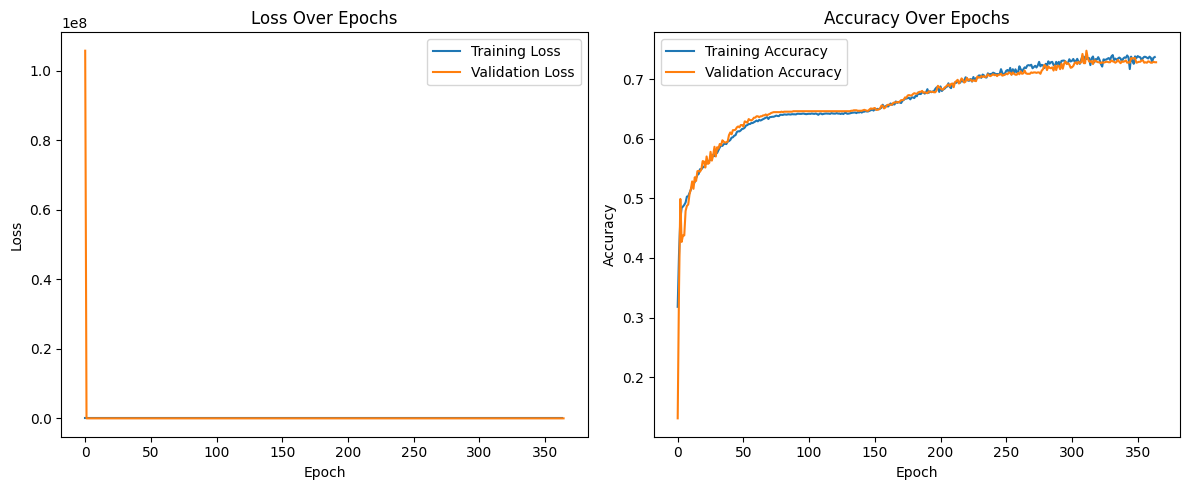

In [20]:
history_callback.plot_history()

In [22]:
trainer.save_checkpoint("transformer4cnn.ckpt")